[View in Colaboratory](https://colab.research.google.com/github/kobybibas/FittingRandomDataToResnetCNN/blob/master/FittingRandomDataWithWideResnet.ipynb)

# Fitting Random Data to Wide Resnet Model
This notebook replicates the results from ["UNDERSTANDING DEEP LEARNING REQUIRES RETHINKING
GENERALIZATION" ](https://arxiv.org/abs/1611.03530).

In this notebook a Resnet model is trained on the CIFAR10 dataset.  The tranining can be done on random labels of the dataset.

The neural network model was taken from https://github.com/xternalz/WideResNet-pytorch.

All the noetbook was inspired by https://github.com/pluskid/fitting-random-labels.

The notebook was developed and tested on https://colab.research.google.com/ with GPU backend.





# Install Dependencies
Installing pytorch

In [4]:
# Install pytorch
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

# Import dependecies 
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Load the Dataset
1. Downloading CIFAR10 dataset.
2. Corrupt the labels based on user's input.
3. Load it to pytorch Dataloader.

In [0]:
# Define general functions

class CIFAR10RandomLabels(datasets.CIFAR10):
    """CIFAR10 dataset, with support for randomly corrupt labels.

    Params
    ------
    corrupt_prob: float
        Default 0.0. The probability of a label being replaced with
        random label.
    num_classes: int
        Default 10. The number of classes in the dataset.
    """
    def __init__(self, corrupt_prob=0.0, num_classes=10, **kwargs):
        super(CIFAR10RandomLabels, self).__init__(**kwargs)
        self.n_classes = num_classes
        if corrupt_prob > 0:
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        labels = np.array(self.train_labels if self.train else self.test_labels)
        np.random.seed(12345)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        # we need to explicitly cast the labels from npy.int64 to
        # builtin int type, otherwise pytorch will fail...
        labels = [int(x) for x in labels]

        if self.train:
            self.train_labels = labels
        else:
            self.test_labels = labels

            
def get_data_loaders(args, shuffle_train=True):

    # Normalization for CIFAR10
    normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

    if args['data_augmentation']==True:
        transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          normalize,
          ])
    else:
        transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize,
          ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
        ])

    kwargs = {'num_workers': 1, 'pin_memory': True}
    train_loader = torch.utils.data.DataLoader(
        CIFAR10RandomLabels(root='./data', train=True, download=True,
                            transform=transform_train, num_classes=args['num_classes'],
                            corrupt_prob=args['label_corrupt_prob']),
        batch_size=args['batch_size'], shuffle=shuffle_train, **kwargs)
    val_loader = torch.utils.data.DataLoader(
        CIFAR10RandomLabels(root='./data', train=False,
                            transform=transform_test, num_classes=args['num_classes'],
                            corrupt_prob=args['label_corrupt_prob']),
        batch_size=args['batch_size'], shuffle=False, **kwargs)
    
    # Labels of CIFAR10 dataset
    label_translation = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
                         'horse', 'ship', 'truck']

    return train_loader, val_loader, label_translation

Files already downloaded and verified
Batch shape: (128, 3, 32, 32)


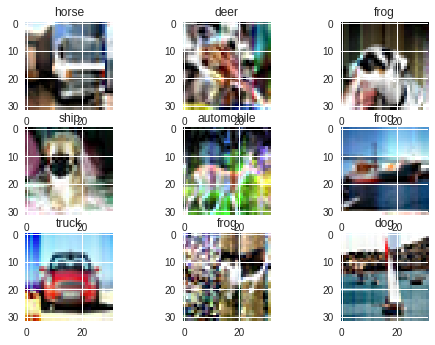

In [6]:
# Define hyperparameters
args = {}
args['num_classes'] = 10 
args['data_augmentation'] = False 
args['label_corrupt_prob'] = 0.0 # replace with 1.0 for totaly random labels
args['batch_size'] = 128
 
# Load the data
train_loader, val_loader, label_translation = get_data_loaders(args, shuffle_train=True)

# Visualize
imgs, label = next(iter(train_loader))
print('Batch shape:',imgs.numpy().shape)

for i in range (0,9):
    idx = np.random.randint(0, imgs.numpy().shape[0])
    img_for_plot = imgs.numpy()[idx,:,:,:].transpose(1, 2, 0)
    img_for_plot -= np.min(img_for_plot, axis=0)
    img_for_plot /= np.ptp(img_for_plot, axis=0)
    label_name = label_translation[label[idx]]
    
    plt.subplot(3,3,i+1)
    plt.imshow(img_for_plot)
    plt.title(label_name)
plt.show()

# Load the Model
1. Define wide Resnet neural netowrk.
2. Load it to pytorch model.

In [0]:
#Define the network

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                                padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                                padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
            out = self.conv1(x)
        else:
            out = self.conv1(self.relu1(self.bn1(x)))

        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(self.relu2(self.bn2(out)))
        if not self.equalInOut:
            return torch.add(self.convShortcut(x), out)
        else:
            return torch.add(x, out)


class NetworkBlock(nn.Module):
        def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
            super(NetworkBlock, self).__init__()
            self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

        def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
            layers = []
            for i in range(nb_layers):
                layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
            return nn.Sequential(*layers)

        def forward(self, x):
            return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, drop_rate=0.0, init_scale=1.0):
        super(WideResNet, self).__init__()

        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                                padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, nChannels[0], nChannels[1], block, 1, drop_rate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, drop_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, init_scale * math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

                size = m.weight.size()
                fan_out = size[0] # number of rows
                fan_in = size[1] # number of columns
                variance = math.sqrt(2.0/(fan_in + fan_out))
                m.weight.data.normal_(0.0, init_scale * variance)


    def forward(self, x):
        out = self.forward_repr(x)
        return self.fc(out)

    def forward_repr(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return out


In [8]:
#Load the model
args['wrn_depth'] = 28
args['wrn_widen_factor'] = 1
drop_rate=args['wrn_droprate'] = 0.0

model = WideResNet(args['wrn_depth'], 
                   args['num_classes'],
                   args['wrn_widen_factor'],
                   drop_rate=args['wrn_droprate'])    
model = torch.nn.DataParallel(model).cuda()
model = model.cuda() 
print('Parameters number: %d' % (sum([p.data.nelement() for p in model.parameters()])))

Parameters number: 369498


# Train the Model

In [0]:
# Define general functions for training

def train_epoch(train_loader, model, criterion, optimizer, epoch, args):
    """Train for one epoch on the training set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    for i, (input, target) in enumerate(train_loader):
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses.avg, top1.avg


def validate_epoch(val_loader, model, criterion, epoch, args):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

    return losses.avg, top1.avg


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [10]:
# Define hyperparameters
args['num_classes'] = 10 
args['epochs'] = 300 
args['learning_rate'] = 0.1
args['momentum'] = 0.9
args['weight_decay'] = 1e-4
args['eval_full_trainset'] = True

# It is possible to countinue training from saved model
#model_path = 'Model_corruptiton_1.0_Acc-tr_61.51.pt'
#model = torch.load(model_path)

# Train
cudnn.benchmark = True

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), args['learning_rate'],
                          momentum=args['momentum'],
                          weight_decay=args['weight_decay'])

# Iterate on ephoces
for epoch in range(0, args['epochs']):
    epoch_time_start = time.time()

    # Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs
    lr = args['learning_rate'] * (0.1 ** (epoch // 150)) * (0.1 ** (epoch // 225))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # train for one epoch
    tr_loss, tr_prec1 = train_epoch(train_loader, model, criterion, optimizer, epoch, args)

    # evaluate on validation set
    val_loss, val_prec1 = validate_epoch(val_loader, model, criterion, epoch, args)

    if args['eval_full_trainset'] == True:
        tr_loss, tr_prec1 = validate_epoch(train_loader, model, criterion, epoch, args)

    epoch_time = time.time() - epoch_time_start

    print('%03d: Acc-tr: %6.2f, Acc-val: %6.2f, L-tr: %6.4f, L-val: %6.4f, epochTime=%10.4f' 
                 % (epoch, tr_prec1, val_prec1, tr_loss, val_loss, epoch_time))    

    model_file_name = 'Model_corruptiton_%2.1f_Acc-tr_%4.2f.pt' % (args['label_corrupt_prob'], tr_prec1)
    
    # Save the model
    if epoch % 50 == 0:
        torch.save(model, model_file_name)
    
    if tr_prec1 > 99.5:
        break

torch.save(model, model_file_name)

000: Acc-tr:  60.08, Acc-val:  10.35, L-tr: 1.1664, L-val: 4.2955, epochTime=   49.2749


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type WideResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type NetworkBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


001: Acc-tr:  64.60, Acc-val:   9.82, L-tr: 1.0240, L-val: 3.9389, epochTime=   47.7215
002: Acc-tr:  49.13, Acc-val:  10.17, L-tr: 1.6116, L-val: 5.1932, epochTime=   47.8408
003: Acc-tr:  63.03, Acc-val:  10.28, L-tr: 1.0768, L-val: 4.2952, epochTime=   47.8763
004: Acc-tr:  66.64, Acc-val:  10.25, L-tr: 0.9600, L-val: 4.3498, epochTime=   47.6391
005: Acc-tr:  66.50, Acc-val:  10.13, L-tr: 0.9555, L-val: 4.1424, epochTime=   47.6955
006: Acc-tr:  63.96, Acc-val:  10.11, L-tr: 1.0150, L-val: 4.4573, epochTime=   47.6459
007: Acc-tr:  70.21, Acc-val:  10.24, L-tr: 0.8670, L-val: 4.3432, epochTime=   47.5467
008: Acc-tr:  65.64, Acc-val:  10.46, L-tr: 1.0315, L-val: 4.3828, epochTime=   47.6796
009: Acc-tr:  48.88, Acc-val:  10.83, L-tr: 1.4903, L-val: 5.2012, epochTime=   47.4702
010: Acc-tr:  56.54, Acc-val:  10.44, L-tr: 1.3881, L-val: 5.0438, epochTime=   47.6749
011: Acc-tr:  70.45, Acc-val:  10.12, L-tr: 0.9035, L-val: 4.6941, epochTime=   47.4280
012: Acc-tr:  63.08, Acc-val:   

048: Acc-tr:  76.83, Acc-val:  10.27, L-tr: 0.6686, L-val: 5.1223, epochTime=   47.8231
049: Acc-tr:  65.87, Acc-val:  10.62, L-tr: 1.1064, L-val: 5.7930, epochTime=   47.8943
050: Acc-tr:  75.19, Acc-val:   9.88, L-tr: 0.7194, L-val: 5.4939, epochTime=   47.7811
051: Acc-tr:  67.30, Acc-val:   9.82, L-tr: 0.9692, L-val: 5.5536, epochTime=   47.6761
052: Acc-tr:  74.98, Acc-val:  10.33, L-tr: 0.7554, L-val: 5.1899, epochTime=   47.8293
053: Acc-tr:  69.76, Acc-val:  10.51, L-tr: 0.8778, L-val: 5.1587, epochTime=   47.6957
054: Acc-tr:  71.52, Acc-val:  10.33, L-tr: 0.8531, L-val: 5.3392, epochTime=   47.7287
055: Acc-tr:  77.41, Acc-val:   9.76, L-tr: 0.6635, L-val: 5.4376, epochTime=   47.6114
056: Acc-tr:  68.46, Acc-val:   9.92, L-tr: 0.9558, L-val: 5.4593, epochTime=   47.5762
057: Acc-tr:  74.60, Acc-val:  10.09, L-tr: 0.7591, L-val: 5.4085, epochTime=   47.7540
058: Acc-tr:  77.86, Acc-val:   9.89, L-tr: 0.6597, L-val: 5.5886, epochTime=   47.5379
059: Acc-tr:  81.16, Acc-val:  1

095: Acc-tr:  79.07, Acc-val:  10.00, L-tr: 0.6234, L-val: 5.4505, epochTime=   47.8196
096: Acc-tr:  70.28, Acc-val:   9.79, L-tr: 0.9014, L-val: 6.1486, epochTime=   48.5959
097: Acc-tr:  68.30, Acc-val:  10.29, L-tr: 0.9837, L-val: 5.7883, epochTime=   47.8111
098: Acc-tr:  74.34, Acc-val:   9.70, L-tr: 0.7662, L-val: 5.3835, epochTime=   47.9216
099: Acc-tr:  69.02, Acc-val:  10.40, L-tr: 0.9889, L-val: 5.6449, epochTime=   47.9630
100: Acc-tr:  56.06, Acc-val:  10.12, L-tr: 1.5650, L-val: 6.5238, epochTime=   47.8557
101: Acc-tr:  68.91, Acc-val:   9.99, L-tr: 0.9297, L-val: 5.9893, epochTime=   47.8340
102: Acc-tr:  75.53, Acc-val:   9.81, L-tr: 0.7281, L-val: 5.5874, epochTime=   47.8769
103: Acc-tr:  70.04, Acc-val:   9.81, L-tr: 0.8977, L-val: 5.9283, epochTime=   48.2571
104: Acc-tr:  67.74, Acc-val:  10.35, L-tr: 1.0541, L-val: 6.0108, epochTime=   48.0069
105: Acc-tr:  73.46, Acc-val:   9.83, L-tr: 0.7777, L-val: 5.7014, epochTime=   47.8683
106: Acc-tr:  68.08, Acc-val:  1

142: Acc-tr:  73.01, Acc-val:   9.95, L-tr: 0.7743, L-val: 5.5534, epochTime=   47.6921
143: Acc-tr:  63.96, Acc-val:   9.92, L-tr: 1.1167, L-val: 6.3869, epochTime=   47.8574
144: Acc-tr:  80.53, Acc-val:  10.14, L-tr: 0.5803, L-val: 4.9906, epochTime=   47.6944
145: Acc-tr:  68.26, Acc-val:  10.22, L-tr: 1.0774, L-val: 6.2482, epochTime=   47.8910
146: Acc-tr:  76.27, Acc-val:   9.93, L-tr: 0.7036, L-val: 5.9341, epochTime=   47.8650
147: Acc-tr:  74.65, Acc-val:  10.18, L-tr: 0.7466, L-val: 5.7840, epochTime=   47.6513
148: Acc-tr:  83.65, Acc-val:   9.93, L-tr: 0.4866, L-val: 5.0432, epochTime=   47.8669
149: Acc-tr:  70.54, Acc-val:   9.62, L-tr: 0.9238, L-val: 5.8393, epochTime=   47.7314
150: Acc-tr:  98.78, Acc-val:   9.60, L-tr: 0.0851, L-val: 5.4966, epochTime=   47.7558
151: Acc-tr:  99.76, Acc-val:   9.64, L-tr: 0.0438, L-val: 5.9035, epochTime=   47.4946


In [15]:
# Download the model
from google.colab import files
!ls
files.download(model_file_name)

data				       Model_corruptiton_1.0_Acc-tr_56.06.pt
datalab				       Model_corruptiton_1.0_Acc-tr_60.08.pt
Model_corruptiton_0.0_Acc-tr_99.98.pt  Model_corruptiton_1.0_Acc-tr_61.51.pt
Model_corruptiton_1.0_Acc-tr_10.24.pt  Model_corruptiton_1.0_Acc-tr_75.19.pt
Model_corruptiton_1.0_Acc-tr_10.39.pt  Model_corruptiton_1.0_Acc-tr_98.78.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type WideResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type NetworkBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
